In [72]:
%matplotlib inline


import pandas as pd
import numpy as np
import regex
import os, sys
import matplotlib.pyplot as plt

# USER INPUTS

In [73]:



"""Experiment name to prepend output files"""
# EXPERIMENT = "18014_graphing-2"
# EXPERIMENT = 'filtered-sample-nh'
EXPERIMENT = 'filtered-ratios'
# EXPERIMENT = '18014'

"""Directory path to input data 
    (filtered; output from '1-read_fastq_id_features)
"""
# FILTERED_FILEPATH = "../output/filtered-sample-nh.csv"
FILTERED_FILEPATH = "../output/filtered-ratios.csv"
# FILTERED_FILEPATH = "../output/filtered-18014.csv"
# FILTERED_FILEPATH = '../../../2016-09-19-validation_graphs_redoes/data/filtered-ratios.csv'
"""Directory path to save output"""
OUTPUT_DIRECTORY = "../output"

"""Minimum number of reads as a baseline. Used to simplify data processing."""
MIN_READS = 100


# PRESETS AND SCRIPT

In [74]:
"""
# NEED TO FIGURE HOW TO RELOAD DEPENDENT FUNCTIONS
UPON VALUE CHANGES
Column names correspoinding to eponymous variables"""

SAMPLE = 'idx'
QTAG = 'qtag'
BARCODE = 'barcode'
READS = 'readsPF'
MCOUNTS = 'mcountsPF'
PERCENT_MCOUNTS = 'percent_%s'%MCOUNTS
GROUPBY = ['idx']# for older versions/ formats

In [75]:
def check_inputs():
    
    # modules
    assert pd
    assert np
    assert regex
    assert os
    assert sys
    
    # user experiment inputs 
    assert EXPERIMENT
    assert FILTERED_FILEPATH
    assert OUTPUT_DIRECTORY
    assert MIN_READS
    
    # user columns
    assert SAMPLE
    assert QTAG
    assert BARCODE
    assert READS
    assert MCOUNTS
    assert PERCENT_MCOUNTS
    assert GROUPBY
    

In [76]:
# 2016-11-04 updated to include filter delete bool feature
"""calculate_percent_molecs
    calculates percent of mcounts of barcodes.
    df: pd.DataFrame() 
    mcounts: str, optional, col to calculate percents, default MCOUNTS
    percent_mcounts: str, col to assign values to, default PERCENT_MCOUNTS
    filters: list, np.array, dict, columns and bool values to filter values
    
    Returns: 
        df with updated percent_mcounts values
"""
def calculate_percent_molecs(df, mcounts=MCOUNTS, percent_mcounts=PERCENT_MCOUNTS, filters=[]):
    """Updates percent molec counters for sample"""
    
    df.loc[:,percent_mcounts] = 0.
    if len(filters) > 0:
        var, val = filters[0]
        cond = (df[var]==val)
        i = 1
        while i < len(filters):
            var, val = filters[i]
            cond = cond & (df[var]==val)
            i+=1
    else:
        cond = ()
    total = df.loc[cond, mcounts].values.sum() / 100.
    df.loc[cond,percent_mcounts] = df.apply(lambda x: x[mcounts]/total, axis=1)
    df.sort_values(by=[percent_mcounts,mcounts, BARCODE], 
                   ascending=[0,0,1], inplace=True)
    return df

In [77]:
def load_data(filtered_file, sample=SAMPLE, qtag=QTAG, 
              barcode=BARCODE, mcounts=MCOUNTS, reads=READS):
    """Loads filtered lib-ID-barcode data csv to dict of samples"""
    columns = [sample, qtag, barcode, mcounts, reads]
    # loads excel file (all tabs)
    
    csv = pd.read_csv(filtered_file)
    # filter out null barcodes just in case (if custom user input)
    csv = csv.loc[(csv[qtag]!='None') & (csv[barcode]!='None')]
    csv = csv[columns]
    csv[sample] = csv[sample].apply(lambda x: str(x))
    # get percent molecs per sample, store as output dict entry 
    groups = csv.groupby(sample)
    data = []
    for i, group in csv.groupby(sample):
        data.append((i,calculate_percent_molecs(group)))
    return data


In [78]:
def check_data(d, sample=SAMPLE, mcounts=MCOUNTS, reads=READS):
    """Check data for proper format, input values, and 
    converts into list-like object if necessary

    d(list, np.array ,dict, or pd.DataFrame): input data
    
    Returns: data set as a list-like object, wherein
        each item is a pair containing sample name (str) and 
        sample data (pd.DataFrame), in that order.
    """
    data_arr = []
    # wrangle data to list of list-like pairs, as "[idx, df]"
    if type(d) in [np.array, list] :
        data_arr = d
    elif type(d) == dict:
        data_arr = d.items()
    elif type(d) == pd.DataFrame :
        data_arr = [(s,df) for s,df in d.groupby(sample)]
    else:
        print "Input data is not in correct format. Please provide \
        list-like, dict, or pd.DataFrame object."
    
    # check input has correct values
    try:
        for a in data_arr:
            assert len(a) == 2, "incorrect item length"
            s, df = a
            assert type(s) == str, 'sample name is not string type'
            assert type(df) == pd.DataFrame, "incorrect value type: must be pd.DataFrame"
            assert sample in df.columns, "%s not in dataframe"%sample
            assert mcounts in df.columns, "%s not in dataframe"%mcounts
            assert reads in df.columns, "%s not in dataframe"%reads
    # if no 
    except IndexError as e:
        print "Item number of values is not 2.\n"
        print "IndexError. ",e.message
        print a
    except ValueError as e:
        print "Sample name could not be converted to float: %s\n"% type(item[i])
        print "ValueError. ",e.message
        print a
    except AssertionError as e:
        print "Assertion failed:"
        print e.message
        print a
    
    return data_arr

In [79]:
"""OLD THRESHOLD"""

def threshold(group, reps_remaining, thresh_mcounts,threshold_log,
             mcounts=MCOUNTS):
    """Thresholds barcodes of a given sample

        group(pd.DataFrame): df containing library-ID-barcodes, 
            mcountsPF and percent_mcountsPF
        reps_remaining(int): reps remaining from max number 
            input from user 
        thresh_val(float or int): initial threshold value (percent_mcountPF)
            provided from previous recursion or user input
        thresh_i(int): initial position of threshold value in 
            percent_mcountsPF list, ranging 0,len(group)

        Returns: 
            None, if thresholding fails;
            passed(pd.DataFrame), if thresholding successful; or
            self, otherwise, with updated threshold values and 
                group df.
    """
#     print "\nSTART", len(group)
    # max out reps
    if reps_remaining <= 0:
        print 'Maxed out reps. Skipping sample.'
    # no barcodes passed threshold 
    elif len(group) == 0:
        print "No barcodes passed threshold. Skipping sample."
    else:
        # calculate new threshold 
        group.sort_values(by=mcounts, ascending=False, inplace=True)
        mcount_vals = group.loc[(group['passed']==True)|(group['is_padding']==True)][mcounts].values
#         mcount_vals = thresh_group[mcounts].values
#         mcount_vals = mcount_vals + [1] if thresh_mcounts < 0 or len(thresh_group) <= 3 else mcount_vals
#         print "G", group
#         print "THRG", thresh_group
#         print"MCV",  mcount_vals
#         print "else", reps_remaining, len(group), len(mcount_vals)
        new_thresh_mcounts = calculate_threshold(mcount_vals)
#         print "after", reps_remaining, len(group), thresh_mcounts, new_thresh_mcounts
        
        threshold_log.append(len(group.loc[group[mcounts]>=new_thresh_mcounts]))
        print '\n',reps_remaining, len(group)
#         print 'old',group.loc[(group[mcounts]>=thresh_mcounts)&(group[mcounts]>1)][['qtag','barcode','mcountsPF','passed','is_padding']]
#         print 'new',group.loc[group[mcounts]>=new_thresh_mcounts][['qtag','barcode','mcountsPF','passed','is_padding']]
#         print len(thresh_group.loc[thresh_group[mcounts]>new_thresh_mcounts])
        
#         print len(group), len(thresh_group)
        # if reached steady state
        if new_thresh_mcounts == thresh_mcounts:
#             re_thresholded_v = calculate_threshold(group.loc[group['passed']==True][mcounts].values)
#             print thresh_mcounts, re_thresholded_v
#             passed = eliminate_oneoffs(group, re_thresholded_v, pad=False)
#             passed = eliminate_oneoffs(group, new_thresh_mcounts, pad=False)
#             print len(group.loc[group['passed']==True]), len(passed.loc[passed['passed']==True])
            print len(group.loc[group['passed']==True]), new_thresh_mcounts
            group.loc[:,'passed'] = group.apply(lambda x:
                            True if (x['passed']==True) and
                            (x['is_padding']==False) and
                            (x[mcounts]>=new_thresh_mcounts) else False, axis=1)
            
            passed_val = calculate_threshold(group.loc[group['passed']==True])
#             passed_val = group.loc[group['passed']==True,mcounts].min()
            group.loc[:,'passed'] = group.apply(lambda x: True if x['passed']==True and x[mcounts]>=passed_val else False,
                                               axis=1)
            print len(group.loc[group['passed']==True]), passed_val

            threshold_log.append(len(group.loc[group[mcounts]>=passed_val]))
            print "\t\t\t", threshold_log
#             group.loc[(group['passed']==True)
#                               &(group['is_padding']==False)
#                               &(group[mcounts]>=thresh_mcounts)]
            
            group = calculate_percent_molecs(group,filters=[['passed',True],['is_padding',False]])
#             passed = calculate_percent_molecs(group, 
#                         filters=[['passed',True],['is_padding',False]])
            group.reset_index(inplace=True,drop=True)
            print "FINAL", len(group.loc[group['passed']==True])
            sys.stdout.write('Thresholded.\n')
            return group, threshold_log
        # recursively clean and re-threshold
        else:
#             print reps_remaining
#             print len(group), thresh_mcounts, new_thresh_mcounts
            # clean up group by eliminating one-offs
            cleaned = eliminate_oneoffs(group,new_thresh_mcounts)
            cleaned.reset_index(inplace=True,drop=True)
#             print reps_remaining, len(cleaned.loc[cleaned['passed']==True])
            # recurse with cleaned df and new threshold values
            return threshold(cleaned, reps_remaining-1, new_thresh_mcounts, threshold_log,
                             mcounts=mcounts)
        
    # if thresholding failed, return None
    sys.stdout.write('Skipped.\n')
    return pd.DataFrame()

In [80]:
# STEP 2: CALCULATE THRESHOLD VALUE via. CONCAVITY


def calculate_threshold(y, by='passed', mcounts=MCOUNTS):
    """Calculates threshold of series with modified concavity approach

        y(np.array or list): list or list-like object of 
            values as floats or ints

        Returns index of inflection point in array, 
            i.e. threshold position.
    """
    def rolling_window(arr):
        """Constructs list of overlapping subarray ranges of size 2"""
        shape = arr.shape[:-1] + (arr.shape[-1]-1, 2)
        strides = arr.strides + (arr.strides[-1],)
        windows = np.lib.stride_tricks.as_strided(arr, 
                              shape=shape, strides=strides)
        return windows
    def first_d_gen(windows):
        """Generates first derivative of windows as relative difference"""
        for w in windows:
            # amended 2016-10-12: normalize by y midpoint instead of second point to 
            # better represent the count magnitude of segment
            yield float(w[1]-w[0])/(w[0]+w[1])*2
    def second_d_gen(windows):
        """Generates second derivative of windows"""
        for w in windows:
            yield w[1]-w[0]       
            
    if type(y) in [np.ndarray, list]:
        x_temp = np.array([])
        y_temp = np.array(y)
    else:
        y = pd.DataFrame(y)
        sortby, cond = [mcounts], (y[mcounts]>0)
        if by in y.columns:
            sortby, cond = ['passed']+sortby, cond&(y['passed']==True) 
        passed = y.loc[cond].sort_values(by=sortby,ascending=False)[mcounts]
        x_temp = passed.index.values
        y_temp = passed.values
    
    
    y_temp = np.sort(np.array(y_temp))[::-1]
    # left and right padding to cover all array vals in derivations
    suffix = [] if len(y_temp) > 2 else [1]
#     suffix=[]
#     suffix = [] if len(y_temp) > 1 else [y_temp[0]]
#     suffix = [y_temp[len(y_temp)-1]/(y_temp[0]+y_temp[1])*2]
#     if len(y_temp) < 2:
#         suffix = [y_temp[len(y_temp)-1]/2]
#     else:
#         suffix =  [y_temp[len(y_temp)-1] -
#                    (y_temp[len(y_temp)-2]-y_temp[len(y_temp)-1])]
    
    yarray = np.concatenate([ [y_temp[0]], y_temp, suffix])
#     print yarray
    # calculates first derivative
    first_windows = rolling_window(yarray)
    first_derivs = np.fromiter(first_d_gen(first_windows), np.float
                               , count=len(first_windows))
    # calculates second derivative
    second_windows = rolling_window(first_derivs)
    second_derivs = np.fromiter(second_d_gen(second_windows), np.float
                                , count=len(second_windows))
    # gets index or position value of inflection point (curves down ), adjust by adding 1
    # for second deriv
    thresh_i = min(np.argmin(second_derivs)+1, len(y_temp)-1)
    thresh_v = y_temp[thresh_i]
    
#     print "min", np.min(second_derivs), np.argmin(second_derivs)
#     print 'max', np.max(second_derivs), np.argmax(second_derivs)
    return thresh_v

In [90]:
def eliminate_oneoffs(g, thresh_val, pad=True,
                      qtag=QTAG, barcode=BARCODE, passed='passed',
                      barcode_error = 'barcode_error',
                      qtag_error = 'qtag_error',
                      mcounts=MCOUNTS):
    """Eliminate barcodes that are one position off from a more-abundant barcode
        group(pd.DataFrame): df containing qtag, barcode, and percent_mcounts columns
        thresh_val(float): threshold value to select high abundant barcodes
            to iterate through as 'major' ones
        pad(bool): if True, adds a right pad so last non-eliminated value 
            can be analyzed in by the threshold() function. Default True.
        qtag, barcode, percent_mcounts, mcounts (str): column names for the corresponding
            argument. Defaults are global vars QTAG, BARCODE, PERCENT_MCOUNTS, MCOUNTS.

        Returns: table of barcodes that passed elimination
        
        For regex package info, see https://pypi.python.org/pypi/regex/
    """
    g.sort_values(by=mcounts, ascending=False, inplace=True)
    g.loc[g[mcounts] < thresh_val, 'passed'] = False
    g.loc[:,'is_padding'] = False
    failed = []
#     print "elim", len(g), thresh_val, len(g.loc[g['passed']==True]), len( g.loc[(g['passed']==True)&(g[mcounts])>=thresh_val])
#     majors = filter_g.loc[(filter_g[mcounts])>thresh_val]
    i = 0
    # add capability to check other parameters, i.e. qtag
#     for maj_i, maj_r in g.loc[(g['passed']==True)&(g[mcounts])>=thresh_val].iterrows():
    for maj_i, maj_r in g.loc[g['passed']==True].iterrows():
        # if it has not yet been tested
        if g.loc[maj_i,'passed'] == True:
#             print 'passed maj', maj_r[mcounts]
#             minors = filter_g.loc[filter_g[mcounts]<maj_r[mcounts]]

            minors = g.loc[(g['passed']==True)&(g[mcounts]<maj_r[mcounts])]

            # for each 'minor' barcode aka. with fewer molecs, test if one-off from major
            for min_i, min_r in minors.iterrows():
                query = regex.search("(%s){s<=1}"% maj_r[barcode], min_r[barcode])
                if query:
                    g.loc[min_i,'passed'] = False
                    g.loc[min_i,'barcode_error'] += 1 if sum(query.fuzzy_counts)>0 else 0
                    g.loc[min_i,'qtag_error'] += 1 if min_r[qtag]!=maj_r[qtag] else 0
#                     if min_r[mcounts] < thresh_val:
                    failed.append([min_i, min_r[mcounts]])
                                          
            i+=1
                    
#     # if requested, adds a right pad  
#     # line added 2016-10-12: combine two conditions: ensure that 
#     # no null rows get added if all barcodes are accepted
#     g.loc[:,'passed'] = g.apply(lambda x: False if g.index in failed else x['passed'], axis=1)
#     print len(g), len(g.loc[g['passed']==False]), len(failed)
#     print "THR VAL",thresh_val
#     print g
#     print g['passed']==False
    if len(failed) > 0:
        failed.sort(key=lambda x: x[1])
        failed = failed[::-1]
    
#     if pad==True and len(failed) > 0:
    if pad==True and len(g) != len(g.loc[g['passed']==False]):
        pad_i = [f[0] for f in failed[:1]]
        pad_i = g.loc[(g['passed']==False),mcounts][:1].index.values
#         print "PADI", pad_i
        for pi in pad_i:
            g.loc[pi,'is_padding'] = True
#         print "PADI ADJ"
#         print g
    return g
            

In [82]:
def run_threshold(d, sample=SAMPLE, qtag=QTAG, barcode=BARCODE, 
                  mcounts=MCOUNTS, reads=READS, percent_mcounts=PERCENT_MCOUNTS,
                  min_reads=MIN_READS, min_mcount=50):
    """Run threshold algorithm for each sample in dataset

        d(np.array, list, dict, or pd.DataFrame): dataset for all samples
        sample, qtag, barcode, mcounts, reads, percent_mcounts(str): columns in df for 
            corresponding vals. Defaults are global vars SAMPLE, QTAG, BARCODE, MCOUNTS, 
            READS, PERCENT_MCOUNTS.
        min_reads(int): minimum number of reads for a library-ID-barcode as an 
            absolute baseline (that which any barcode below is highly likely to be 
            false.) Default is global var MIN_READS.
        min_mcount(int): minimum number of molecs for library-ID-barcode as an
            absolute baseline. Default is 50.

        Note: min_reads and min_mcount are applied to increase performance.

        Returns: 
            pd.DataFrame, if successful, of 'true' (passed) library-ID-barcodes 
                for all samples
            None, if no samples had passing library-ID-barcodes.
    """
    passed = []
    all_threshold_logs = {}
    counter = 1
    # checks and formats data (d) to list-like obj of pairs
    data_arr = check_data(d, sample=sample, mcounts=mcounts, reads=reads)
    # run for each (sample, df) in dataset 
    for s, group in data_arr:
        sys.stdout.write("\n-------------\nSample %d of %d (%s): "%(counter,len(data_arr),s))
        # select valid data meeting absolute baseline 
        g = group.loc[(group[qtag] != 'None') & (group[barcode] != 'None') ]
#                           & (group[mcounts] > min_mcount)
#                           & (group[reads] > min_reads)]
        if len(g)>0:
            g.loc[:,'passed'] = True
            g.loc[:,'qtag_error'] = False
            g.loc[:,'barcode_error'] = False
            g.loc[:,'is_padding'] = False
            result, tlogs = threshold(g, 20, -1, [])
            passed.append(result)
            all_threshold_logs[s] = tlogs
        sys.stdout.flush()
        counter += 1


    # if we do have data (i.e. some barcodes that passed in the samples)
    if len(passed) > 0:
        # concat all df together
        passeddf = pd.concat(passed)
        passeddf.sort_values(by=[sample,percent_mcounts]
                             ,ascending=[True, False]
                             ,inplace=True)
        passeddf.reset_index(inplace=True,drop=True)
        return passeddf, all_threshold_logs
    else:
        print "No samples were successfully thresholded."
    return 

### SCRIPT TO SAVE DATA TO CSVs

In [83]:
def save_data(filtered,passed, output_directory=OUTPUT_DIRECTORY, experiment=EXPERIMENT):
    
    # Save passed dataframe
    passed.to_csv('%s/threshold-%s-passed.csv'%(output_directory,experiment), index=False)
    # count and save results
    counts = count_sample_barcodes(passed)
    counts.to_csv('%s/threshold-%s-counts.csv'%(output_directory,experiment), index=False)
    # merge passed and filtered data and save
    fc_temp = pd.concat([d[1] for d in filtered])
    filtered_concat = apply_passed_data(fc_temp, passed)
    filtered_concat.to_csv('%s/threshold-%s-merged.csv'%(output_directory,experiment), index=False)

In [84]:
def count_sample_barcodes(df, groupby=SAMPLE, barcode=BARCODE, sample=SAMPLE, qtag=QTAG
                      , percent_mcounts=PERCENT_MCOUNTS):
    """Counts passed barcodes per sample and saves as csv
    
        df(pd.DataFrame): input dataframe containing passed 
            barcodes of all samples
        groupby(str or list-like): columns to group samples by
    """
    agg = df.groupby(groupby).agg(len)
    counts = agg[agg.columns[0]]
    counts.name = 'count'
    counts = pd.DataFrame(counts)
    counts.reset_index(inplace=True)
    return counts



In [85]:
def apply_passed_data(filtered, passeddf, sample=SAMPLE, qtag=QTAG
                      , barcode=BARCODE, percent_mcounts=PERCENT_MCOUNTS):
    """Cross reference passed barcodes with raw filtered data
        filtered(pd.DataFrame): raw filtered data as dataframe for all samples
        passed(pd.DataFrame): data passed threshold (output of run_threshold)
        sample,qtag,barcode,percent_mcounts(str): names corresponding to df columns.
            Defaults are SAMPLE,QTAG,BARCODE,PERCENT_MCOUNTS.

        Returns:
            filtered(pd.DataFrame) updated with 'passed_threshold' and 
            percent_mcounts columns
    """
    def cross_ref_passed(row):
        key = (row[sample],row[qtag],row[barcode])
        if key in passed_indexed.index:
            row.loc[:,percent_mcounts+'_thresholded'] = passed_indexed.loc[key,percent_mcounts]
            row.loc[:,'passed_threshold'] = True
        return row

    passed_indexed = passeddf.set_index([sample,qtag,barcode])
    filtered.rename(columns={percent_mcounts:percent_mcounts+'_filtered'})
    filtered.loc[:,'passed_threshold'] = False
    filtered.loc[:,percent_mcounts+'_thresholded'] = 0
    filtered = filtered.apply(cross_ref_passed, axis=1)
    return filtered



# EXECUTE SCRIPT BELOW

In [91]:
if __name__=='__main__':
    # Check all inputs exist and are valid
    check_inputs()
    # Runs data loading in script
    filtered = load_data(FILTERED_FILEPATH)
    # Run thresholding of all samples in dataset
    passeddf, all_threshold_logs = run_threshold(filtered)
#     save_data(filtered, passeddf, output_directory=OUTPUT_DIRECTORY, experiment=EXPERIMENT)

C:\Users\vwl698\Anaconda2\lib\site-packages\ipykernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-------------
Sample 1 of 27 (1): 
20 30

19 30
1 266
1 79618
			[2, 2, 1]
FINAL 1
Thresholded.

-------------
Sample 2 of 27 (10): 
20 89

19 89
2 15702
2 15702
			[2, 2, 2]
FINAL 2
Thresholded.

-------------
Sample 3 of 27 (11): 
20 52

19 52
2 7883
2 7883
			[2, 2, 2]
FINAL 2
Thresholded.

-------------
Sample 4 of 27 (12): 
20 43

19 43
2 3712
2 3712
			[2, 2, 2]
FINAL 2
Thresholded.

-------------
Sample 5 of 27 (13): 
20 49

19 49
2 200
2 200
			[2, 2, 2]
FINAL 2
Thresholded.

-------------
Sample 6 of 27 (14): 
20 90

19 90
3 1820
2 16209
			[4, 4, 2]
FINAL 2
Thresholded.

-------------
Sample 7 of 27 (15): 
20 91

19 91
3 1629
2 10116
			[4, 4, 2]
FINAL 2
Thresholded.

-------------
Sample 8 of 27 (16): 
20 94

19 94
2 6945
2 6945
			[2, 2, 2]
FINAL 2
Thresholded.

-------------
Sample 9 of 27 (17): 
20 69

19 69
4 636
3 2852
			[5, 5, 3]
FINAL 3
Thresholded.

-------------
Sample 10 of 27 (18): 
20 147

19 147

18 147
4 6461
4 6461
			[28, 4, 4, 4]
FINAL 4
Thresholded.

----

In [92]:
fconcat = pd.concat([d[1] for d in filtered if d[0][:2]!="VL" ])
merged = fconcat.merge(passeddf, 
              on=['idx','qtag','barcode','mcountsPF','readsPF'], 
                       how='outer')
merged.drop(['percent_mcountsPF_x','is_padding'],axis=1, inplace=True)
merged.rename(columns={'percent_mcountsPF_y':"percent_mcountsPF"}, inplace=True)
merged = merged.fillna(value={'passed':False,'qtag_error':False,'barcode_error':False,
                    'percent_mcountsPF':0.})

In [97]:
passeddf.loc[passeddf['passed']==True].groupby('idx').apply(len)
passeddf.to_csv("%s/thresholded-%s.csv"%(OUTPUT_DIRECTORY,EXPERIMENT), index=False)

In [94]:
passeddf.loc[passeddf['passed']==True].groupby('idx').apply(len)


idx
1     1
10    2
11    2
12    2
13    2
14    2
15    2
16    2
17    3
18    4
19    5
2     1
20    4
21    2
22    2
23    2
24    3
25    4
26    2
27    2
3     2
4     1
5     1
6     2
7     2
8     2
9     2
dtype: int64

In [98]:
lib_name = 'ratios'
# custom to fix error
# passeddf['newidx'] = passeddf.idx.apply(lambda x: "%s-%s%s"%(lib_name, "0" if len(x)<7 else "", x.split('18014')[-1]))
passeddf['newidx'] = passeddf.idx.apply(lambda x: "%s-%s%s"%(
        lib_name, "0" if len(x.split("-")[-1])<2 else "", x.split('-')[-1]))
passeddf.idx = passeddf.newidx
passeddf.drop("newidx",axis=1,inplace=True)

In [99]:
passeddf.loc[(passeddf['passed']==True)|(passeddf.mcountsPF>500)]

idx qtag  barcode  mcountsPF  readsPF  percent_mcountsPF passed  \
0     ratios-01  q19  GGGCGGC      79618   102145         100.000000   True   
30    ratios-10  q24  CCAGTTG      41816    47259          72.700720   True   
31    ratios-10  q24  ATTCGCT      15702    16376          27.299280   True   
32    ratios-10  q25  ACAATGA       9662     9910           0.000000  False   
33    ratios-10  q24  ACAATGA       2339     2353           0.000000  False   
34    ratios-10  q25  CCAGTTG       2249     2258           0.000000  False   
35    ratios-10  q24  CCCGTTG       1520     1521           0.000000  False   
36    ratios-10  q25  ATTCGCT        829      830           0.000000  False   
37    ratios-10  q24  CTTCGCT        538      538           0.000000  False   
119   ratios-11  q26  CGTAAAC      81232   104913          91.154127   True   
120   ratios-11  q27  GCGGTAG       7883     8044           8.845873   True   
121   ratios-11  q27  CGTAAAC       3772     3819           0.000000  False   
122   ratios-11  q26  GCGGTAG       1118     1122           0.000000  False   
171   ratios-12  q19  CTGGCGT      78535   100514          95.486765   True   
172   ratios-12  q24  GCTTTAG       3712     3739           4.513235   True   
173   ratios-12  q24  CTGGCGT       2300     2316           0.000000  False   
174   ratios-12  q19  GCTTTAG        755      756           0.000000  False   
214   ratios-13  q25  CCCGTCT      69129    85469          99.711520   True   
215   ratios-13  q26  CATATAT        200      201           0.288480   True   
263   ratios-14  q19  GGGCGGC      21111    22459          56.567524   True   
264   ratios-14  q27  CGCATAG      16209    16977          43.432476   True   
265   ratios-14  q24  CAGAAGT      14354    14904           0.000000  False   
266   ratios-14  q24  GGGCGGC       1820     1829           0.000000  False   
267   ratios-14  q27  GGGCGGC       1689     1694           0.000000  False   
268   ratios-14  q24  CGCATAG       1400     1404           0.000000  False   
269   ratios-14  q19  CGCATAG       1332     1337           0.000000  False   
270   ratios-14  q19  CAGAAGT       1306     1311           0.000000  False   
271   ratios-14  q27  CAGAAGT       1239     1243           0.000000  False   
353   ratios-15  q25  GGAGCCA      17705    18607          63.638978   True   
354   ratios-15  q27  GAGGAGT      10116    10409          36.361022   True   
...         ...  ...      ...        ...      ...                ...    ...   
1730  ratios-26  q27  CGTAAAC       1191     1194           0.000000  False   
1731  ratios-26  q25  CCCGTCT       1080     1082           0.000000  False   
1732  ratios-26  q26  CTGGCGT        992      997           0.000000  False   
1733  ratios-26  q24  CGTAAAC        837      837           0.000000  False   
1734  ratios-26  q27  CTGGCGT        655      657           0.000000  False   
1735  ratios-26  q26  GCGGTAG        613      613           0.000000  False   
1736  ratios-26  q19  GCGGTAG        539      540           0.000000  False   
1827  ratios-27  q25  ACAATGA          1        1          50.000000   True   
1828  ratios-27  q26  CGTAAAC          1        1          50.000000   True   
1829  ratios-03  q24  GCTTTAG         40       40          93.023256   True   
1830  ratios-03  q25  GGAGCCA          3        3           6.976744   True   
1836  ratios-04  q24  GCTTTAG      89143   118591         100.000000   True   
1867  ratios-05  q27  CGCATAG      71214    88842         100.000000   True   
1896  ratios-06  q25  GGAGCCA          5        5          71.428571   True   
1897  ratios-06  q27  CGCATAG          2        2          28.571429   True   
1905  ratios-07  q19  GGGCGGC      43283    49084          56.549517   True   
1906  ratios-07  q24  CAGAAGT      33257    36561          43.450483   True   
1907  ratios-07  q24  GGGCGGC       6222     6313           0.000000  False   
1908  ratios-07  q19  CAGAAGT       4281     4322           0.

In [100]:
shortdf = passeddf.loc[passeddf['passed']==True].copy()
shortdf.drop(["passed",'qtag_error','barcode_error','is_padding'], axis=1, inplace=True)
shortdf = shortdf.loc[shortdf.mcountsPF>100]
shortdf.reset_index(inplace=True,drop=True)

In [101]:
# manual wrangling to remove false positives
def apply_calculate_percent_molecs(g):
    total = g.mcountsPF.values.sum()/100.
    g[PERCENT_MCOUNTS] = g.mcountsPF.apply(lambda x: x/total)
    return g
shortdf = shortdf.groupby('idx').apply(apply_calculate_percent_molecs)
shortdf.sort_values(by=['idx','percent_mcountsPF'],ascending=[1,0],inplace=True)

In [102]:
shortdf.head()

idx qtag  barcode  mcountsPF  readsPF  percent_mcountsPF
0   ratios-01  q19  GGGCGGC      79618   102145         100.000000
27  ratios-02  q24  CAGAAGT      75662    95471         100.000000
47  ratios-04  q24  GCTTTAG      89143   118591         100.000000
48  ratios-05  q27  CGCATAG      71214    88842         100.000000
49  ratios-07  q19  GGGCGGC      43283    49084          56.549517

In [103]:
shortdf.to_csv('%s/passed-%s.csv'%(OUTPUT_DIRECTORY, EXPERIMENT), index=False)

## GRAPHING

In [60]:
itypes = {
    (True,False,False):'passed', #passed
    (False,True,False):'qtag mismatch', #qtag error
    (False,False,True):'barcode oneoff', #barcode error
    (False,False,False):'other error', #not one-off
    (False,True,True):'other error'
}

for itype in itypes:
    keys = ['passed','qtag_error','barcode_error']
    ca = [(merged[k]==v) for k,v in zip(keys,itype)]
    cond = ca[0]&ca[1]&ca[2]
    merged.loc[(cond),'itype'] = itypes[itype]
    
ctypes = {
    'passed':'#11BF08',
    'barcode oneoff': '#DE092B',
    'qtag mismatch':'#EBA709',
    'other error':'#2A52D5'
}
itype_order = [
    'passed',
    'other error',
    'barcode oneoff',
    'qtag mismatch'
]

1 1 2
1 2 1
10 1 2
11 1 2
12 1 2
13 1 2
14 1 4
14 2 2
15 1 4
15 2 2
16 1 39
16 3 2
17 1 42
17 3 13
18 1 147
19 1 79
2 1 2
2 2 1
20 1 6
20 3 4
21 1 6
21 2 2
22 1 67
22 3 2
23 1 42
23 3 2
24 1 6
24 2 3
25 1 103
26 1 102
4 1 2
4 2 1
5 1 2
5 2 1
7 1 3
7 2 2
8 1 3
8 2 2
9 1 2


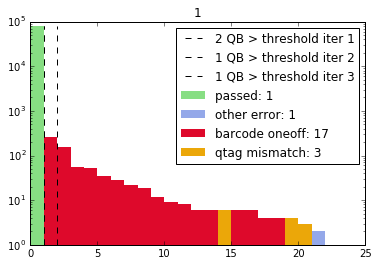

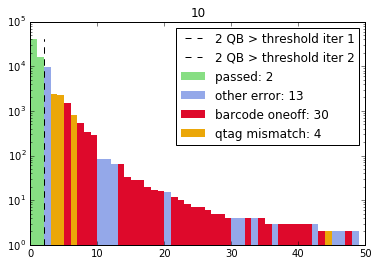

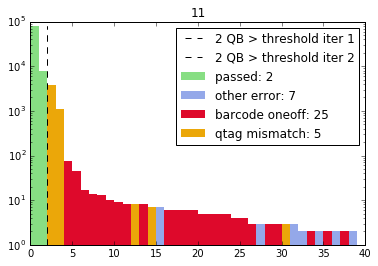

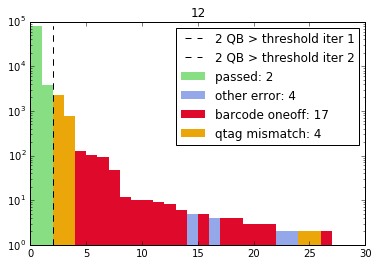

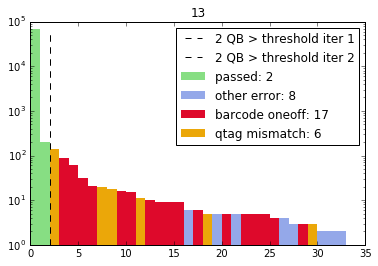

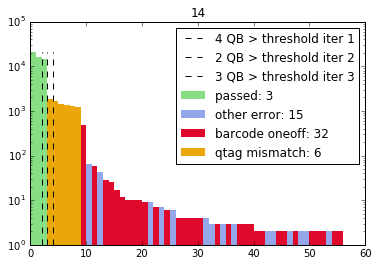

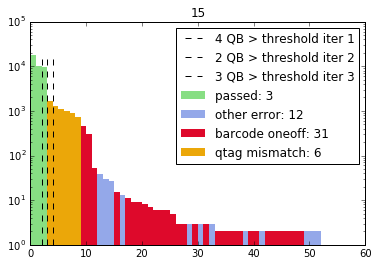

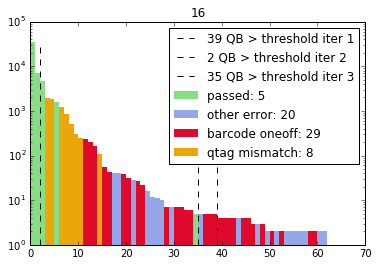

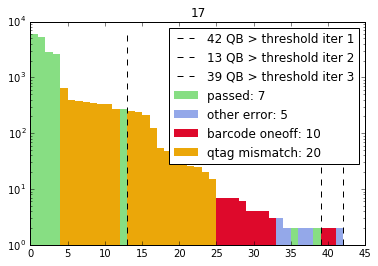

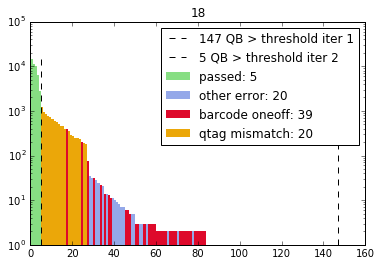

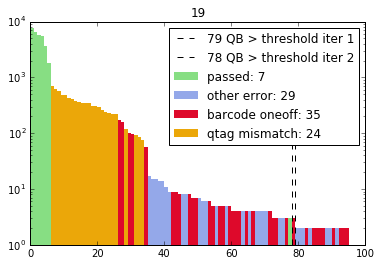

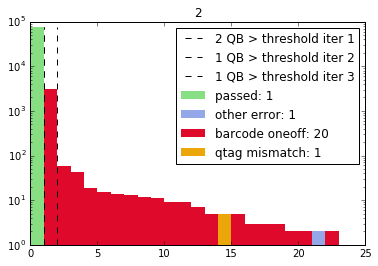

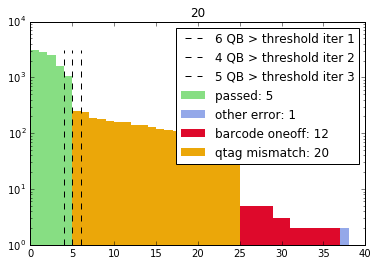

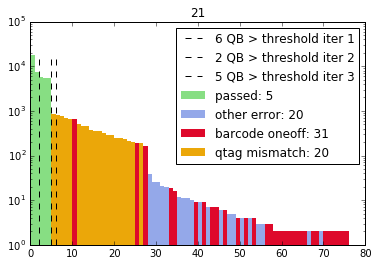

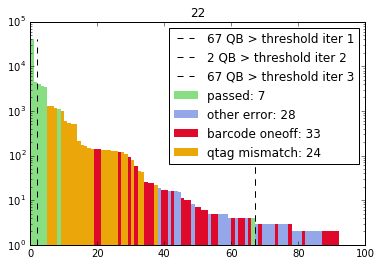

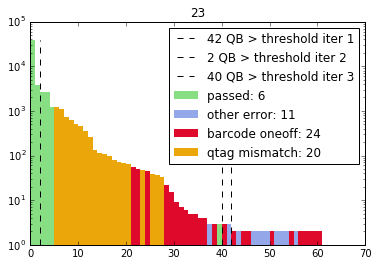

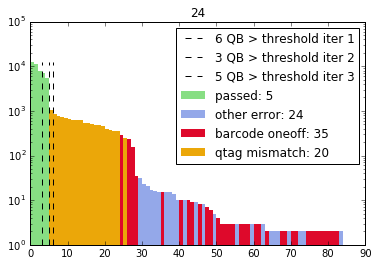

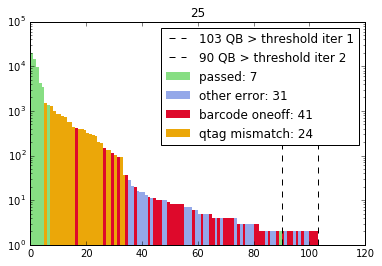

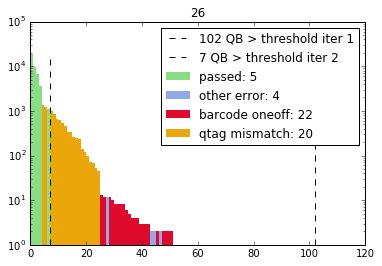

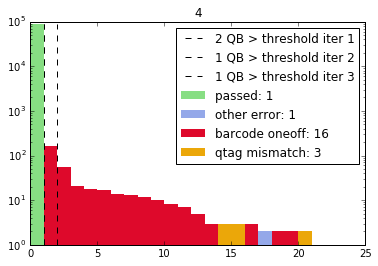

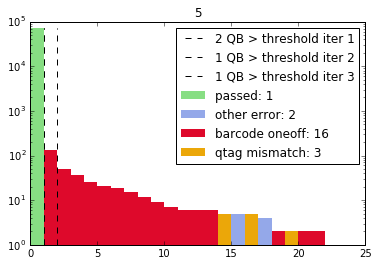

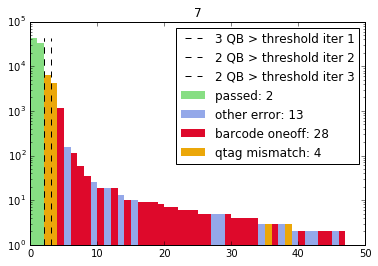

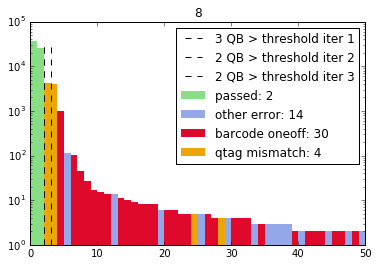

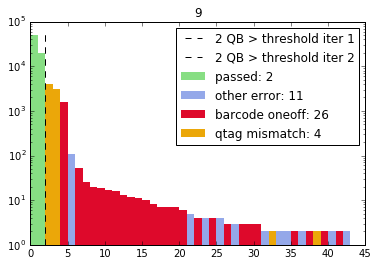

In [63]:
# plots scatter
plottype = 'bar'
mcounts=MCOUNTS
counter = 0
for idx, group in merged.groupby('idx'):
#     if idx[:2]=='NH':
    if group[mcounts].sum()>1000:
        gslice = group.sort_values(by=mcounts,ascending=False)
        gslice = gslice.loc[gslice[mcounts]>1]
        counts = gslice[mcounts].values
        itypes = gslice.itype.values
        it_present= np.unique(itypes)
        
        f, ax = plt.subplots(1)
        for itype in itype_order:
            if itype in it_present:
                x = np.where(itypes==itype)[0]
                y = counts[x]
                label = "%s: %d"%(itype,len(x))
                color = ctypes[itype]
                alpha = 0.5 if itype in ['passed','other error'] else 1
                edgecolor=color
                lw = 1.5
                s = 250 if itype in ['barcode oneoff','qtag mismatch'] else 8
                marker = "|" if itype in ['barcode oneoff','qtag mismatch'] else "-o-"
                    
                if plottype == 'scatter':
                    ax.scatter(x+1, y, color=color, edgecolors=edgecolor,
                            alpha=alpha, label=label, 
                            marker=marker, lw=lw, s=s)
                    
                else:
                    ax.bar(x, y, color=color, alpha=alpha, 
                           label=label, lw=0, width=1 )
        
        thresh_values = all_threshold_logs[idx]
        thresh_line_fmts = [1, 0.5]
        last_round = 1
        last_val = 0
        for tline in range(1,len(thresh_values)):
            
            thresh_line = thresh_values[tline] 
            if thresh_line != last_val:
                print idx,tline, thresh_line
    #             thresh_line =np.max(np.where(itypes=='passed')[0])+1
    #             alpha = thresh_line_fmts[len(thresh_values)-tline-1]
                alpha = 1
                ax.plot([thresh_line,thresh_line],[1,max(counts)], 
                        color = 'black', alpha = 1, ls = '--',
                        label='%d QB > threshold iter %d'%(thresh_line, last_round))
                last_val = thresh_line
                last_round += 1
        thresh_line =np.max(np.where(itypes=='passed')[0])+1
        ax.plot([thresh_line,thresh_line],[1,max(counts)], 
                color = 'black', alpha = 1, ls = '--',
                label='%d QB > threshold iter %d'%(thresh_line, last_round))
        
        ax.set_yscale('log')
        ax.set_xlim(0)
        ax.legend()
        ax.set_title(idx)
        f.savefig('../output/%s_%s.png'%(EXPERIMENT, idx))
#         break


    

In [37]:
calculate_threshold(merged.loc[(merged.idx=='17')&(merged['passed']==True)].mcountsPF.values)

268

In [62]:
merged.loc[(merged.idx=='15')&(merged['passed']==True)]

idx qtag  barcode  mcountsPF  readsPF  percent_mcountsPF passed  \
353  15  q25  GGAGCCA      17705    18607          47.230966   True   
354  15  q27  GAGGAGT      10116    10409          26.986075   True   
355  15  q26  CGCTTTG       9665     9944          25.782959   True   

    qtag_error barcode_error   itype  
353      False         False  passed  
354      False         False  passed  
355      False         False  passed